### Demographics API

Below we have the code that retrieves the data from the  Mechanical Turk Tracker Demographics API.

In [1]:
!sudo -H pip3 install -U pip

Requirement already up-to-date: pip in /usr/local/lib/python3.5/dist-packages


In [2]:
!sudo -H pip3 install -U pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.5/dist-packages
Requirement already up-to-date: pytz>=2011k in /usr/local/lib/python3.5/dist-packages (from pandas)
Requirement already up-to-date: numpy>=1.9.0 in /usr/local/lib/python3.5/dist-packages (from pandas)
Requirement already up-to-date: python-dateutil>=2 in /usr/local/lib/python3.5/dist-packages (from pandas)
Requirement already up-to-date: six>=1.5 in /usr/local/lib/python3.5/dist-packages (from python-dateutil>=2->pandas)


In [3]:
import pandas as pd
pd.__version__

'0.21.0'

In [4]:
!sudo -H pip install -U numpy

Requirement already up-to-date: numpy in /usr/local/lib/python3.5/dist-packages


In [5]:
import numpy as np
np.__version__

'1.13.3'

In [6]:

df = pd.read_csv("mturk_surveys.csv")
df.drop(df.columns[0], axis=1, inplace=True) # drop the "index" column
# We now transform our API answer into a flat table
# and set the right data types
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df["hit_creation_date"]=pd.to_datetime(df["hit_creation_date"])
df["household_income"]=df["household_income"].astype("category")
df["household_size"]=df["household_size"].astype("category")
df["location_country"]=df["location_country"].astype("category")
df["marital_status"]=df["marital_status"].astype("category")
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))
df['time'] = df['hit_answered_date'].apply(lambda x : x.time())
# df['time'] = map(lambda x : x.time(), df['hit_answered_date'])
df.dtypes

gender                             object
hit_answered_date          datetime64[ns]
hit_creation_date          datetime64[ns]
household_income                 category
household_size                   category
location_city                      object
location_country                 category
location_region                    object
marital_status                   category
post_to_completion_secs           float64
worker_id                          object
year_of_birth                       int64
date                       datetime64[ns]
time                               object
dtype: object

In [7]:
import datetime
import time

minDate = min(df['hit_answered_date'])
maxDate = max(df['hit_answered_date'])

# The following are for setting up the x-axis in the plots that
# show demographics over time
min_x = minDate.toordinal()
max_x = maxDate.toordinal()
ticks = 6
steps = (max_x-min_x)/ticks

days = (maxDate - minDate).days
print(minDate)
print(maxDate)
print(days)

2015-03-26 11:47:28.877000
2017-08-02 02:46:35.436000
859


In [8]:
print(min_x)
print(max_x)

735683
736543


In [9]:
len(set(df.worker_id))

39461

In [10]:
# Fix a data quality issue
#fix = list(df[df.gender=='Female'].index)[0]
#df = df.set_value(fix, 'gender', 'female')

In [11]:
df.head(5)

,gender,hit_answered_date,hit_creation_date,household_income,household_size,location_city,location_country,location_region,marital_status,post_to_completion_secs,worker_id,year_of_birth,date,time
0,female,2017-08-02 02:46:35.436,2017-08-02 02:37:10,"Less than $10,000",4,san diego,US,ca,single,565.0,3e24750deb3d82799bced4b315138f1e,1988,2017-08-02,02:46:35.436000
1,male,2017-08-02 02:25:08.336,2017-08-02 02:22:10,"$25,000-$39,999",3,melbourne,US,fl,single,178.0,cfed9a7aabc3ccc23b1df398ed5bba93,1980,2017-08-02,02:25:08.336000
2,male,2017-08-02 02:08:59.835,2017-08-02 02:07:10,"$60,000-$74,999",3,broward county,US,fl,single,109.0,147e4698fe36ddb28514b56b97732566,1993,2017-08-02,02:08:59.835000
3,female,2017-08-02 01:53:21.343,2017-08-02 01:37:10,"$60,000-$74,999",1,columbia,US,md,single,971.0,0d09e9d1cb7cc154b8622d5618e2dcd4,1989,2017-08-02,01:53:21.343000
4,female,2017-08-02 01:24:49.337,2017-08-02 01:22:11,"$15,000-$24,999",2,boca raton,US,fl,engaged,158.0,f33dca374afd358ffc8afeac894e8ab6,1984,2017-08-02,01:24:49.337000


### Exploratory plots

In [12]:
!sudo -H pip3 install -U matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.5/dist-packages
Requirement already up-to-date: cycler>=0.10 in /usr/local/lib/python3.5/dist-packages (from matplotlib)
Requirement already up-to-date: numpy>=1.7.1 in /usr/local/lib/python3.5/dist-packages (from matplotlib)
Requirement already up-to-date: python-dateutil>=2.0 in /usr/local/lib/python3.5/dist-packages (from matplotlib)
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /usr/local/lib/python3.5/dist-packages (from matplotlib)
Requirement already up-to-date: pytz in /usr/local/lib/python3.5/dist-packages (from matplotlib)
Requirement already up-to-date: six>=1.10 in /usr/local/lib/python3.5/dist-packages (from matplotlib)


In [13]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
mpl.__version__

'2.1.0'

In [14]:
!sudo -H pip3 install -U seaborn

Requirement already up-to-date: seaborn in /usr/local/lib/python3.5/dist-packages


In [15]:
import seaborn as sns
sns.__version__

'0.8.1'

In [90]:
mpl.rc("figure", figsize=(16, 8))
mpl.rcParams.update({'font.size': 22})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")

#### Countries of the workers

In [17]:
# Let's see the top countries
country = 100* df['location_country'].value_counts() / len(df)

In [80]:
pd.DataFrame(country.head(30))

,location_country
US,75.262392
IN,16.466495
CA,1.132397
GB,0.713517
PH,0.351434
VE,0.276887
DE,0.272154
FR,0.260321
IT,0.222456
ZZ,0.197607


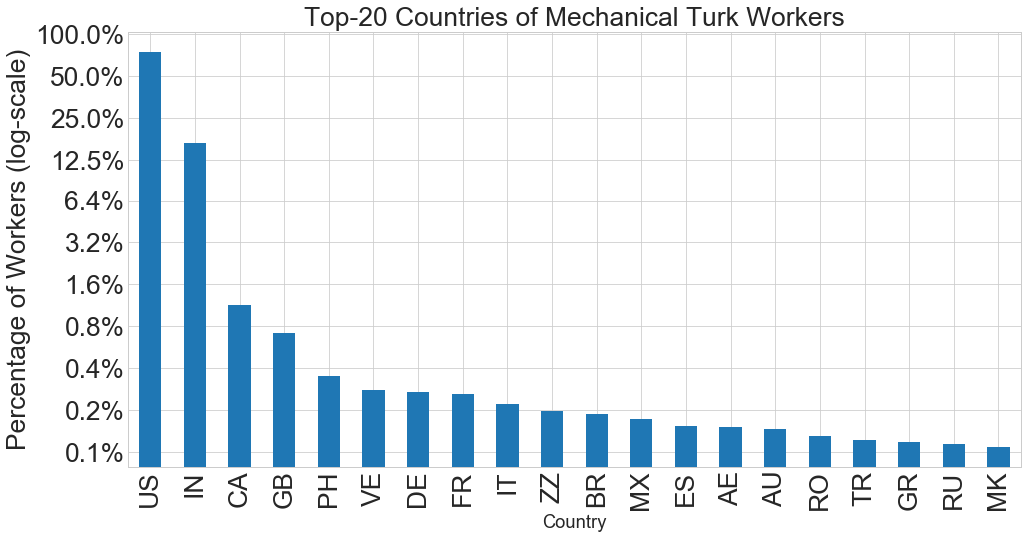

In [98]:
ax = country.head(20).plot.bar(log=True, fontsize='large', color=sns.color_palette(n_colors=1))
ax.set_title("Top-20 Countries of Mechanical Turk Workers", fontsize='large')
ax.set_xlabel("Country", fontsize='small')
ax.set_ylabel("Percentage of Workers (log-scale)", fontsize='large')

fmt = '%.1f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.set_yticks([0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.5, 25, 50, 100])
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig = ax.get_figure()
fig.savefig('plots/countries.pdf', bbox_inches='tight')

In [20]:
country_table = pd.crosstab(index=df.date, columns=df.location_country, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')
# country_table

In [21]:
def time_plot(data, title, filename, confidence=True, legend=False):
        # Compute the mean, and the 10%, 25%, 75%, and 90% percentile
    # Values calculated over a rolling 30-day window
    # Plot lines are smoothed using a 7-day exponential weighted window
    m = data.rolling(window=30).mean().ewm(span=7).mean()
    s1 = data.rolling(window=30).quantile(quantile=0.25).ewm(span=7).mean()
    s2 = data.rolling(window=30).quantile(quantile=0.75).ewm(span=7).mean()
    #s3 = country_table['US'].rolling(window=30).quantile(quantile=0.1).ewm(span=7).mean()
    #s4 = country_table['US'].rolling(window=30).quantile(quantile=0.9).ewm(span=7).mean()

    ax = m.plot(fontsize='small')
    if confidence:
        ax = s1.plot(fontsize='small', color='#bbbbff', linestyle = '--', ax = ax)
        ax = s2.plot(fontsize='small', color='#bbbbff', linestyle = '--', ax = ax)
        
        
    #ax = s3.plot(fontsize='small', color='#eeeeff', linestyle = '--', ax = ax)
    #ax = s4.plot(fontsize='small', color='#eeeeff', linestyle = '--', ax = ax)

    ax.set_title(title, fontsize='large')
    ax.set_ylabel("Percentage", fontsize='small')
    ax.set_xlabel("Date", fontsize='small')
    
    fmt = '%3.1f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)
    
    if legend:
        ax.legend( fontsize='small', fancybox=True, frameon = True)
        

            
          
    #ax.xaxis.set_ticks(np.arange(min_x, max_x, steps))
    #ax.yaxis.set_ticks(np.arange(0.55, 0.91, 0.05))
    fig = ax.get_figure()
    fig.savefig(filename, bbox_inches='tight')
    
    return ax


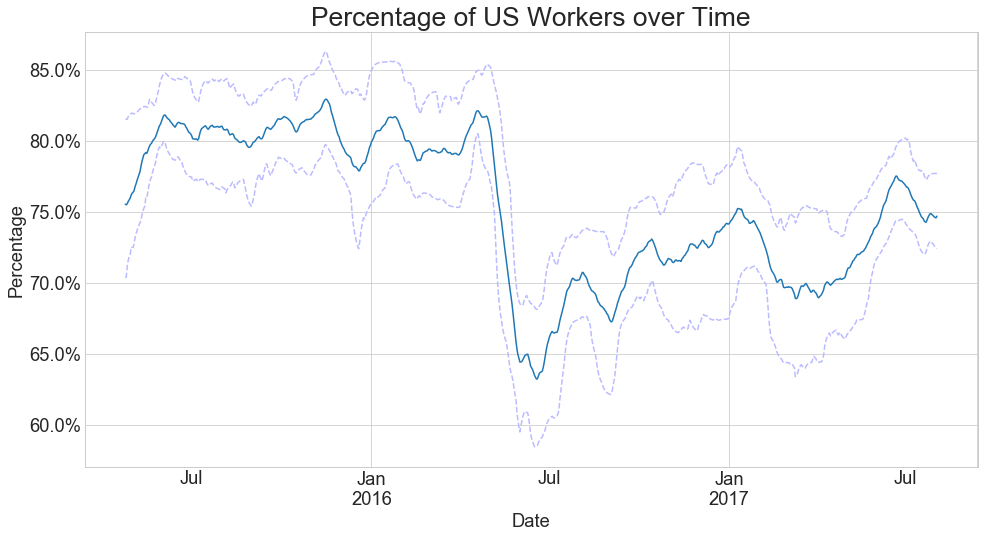

In [22]:
time_plot(100*country_table['US'], 'Percentage of US Workers over Time', 'plots/country-us.pdf')

In [23]:
country_table_time = pd.crosstab(index=df.time, 
                                 columns=df.location_country, 
                                 values='worker_id', 
                                 aggfunc=np.count_nonzero, 
                                 normalize='index')
country_table_time.sort_index(inplace=True)

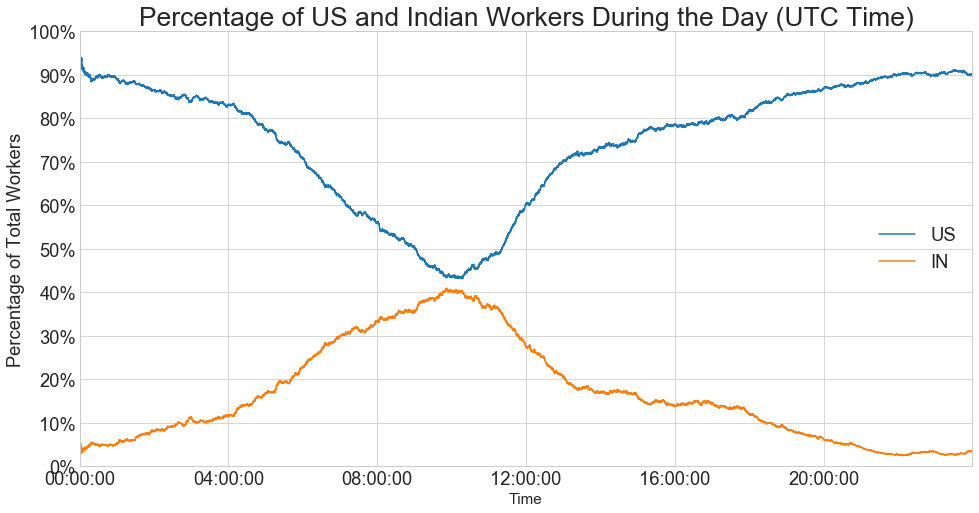

In [99]:
m = 100*country_table_time[['US','IN']].ewm(span=3600).mean()

ax = m.plot( fontsize='small', xlim=[0,86400], ylim=[0,1])
ax.set_title("Percentage of US and Indian Workers During the Day (UTC Time)", fontsize='large')
ax.set_ylabel("Percentage of Total Workers", fontsize='small')
ax.set_xlabel("Time", fontsize='x-small')
ax.xaxis.set_ticks(np.arange(0, 84400, 14400))
ax.yaxis.set_ticks(np.arange(0, 110, 10))
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
    
ax.legend( fontsize='small')
fig = ax.get_figure()
fig.savefig('plots/country-usa-india-time-of-day.pdf', bbox_inches='tight')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  after removing the cwd from sys.path.


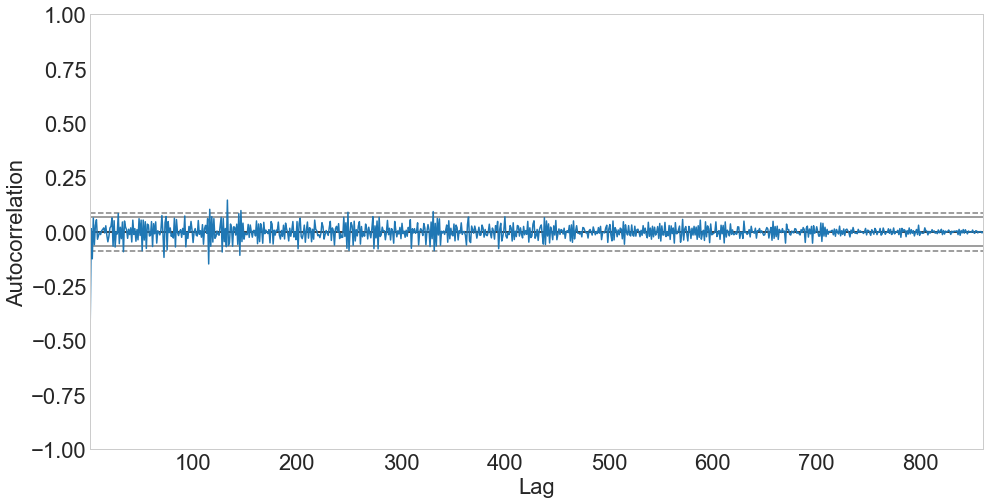

In [25]:
# No significant periodicity
from pandas.tools.plotting import autocorrelation_plot
data = country_table['US'].ewm(span=1).mean().diff()[1:]
autocorrelation_plot(data)

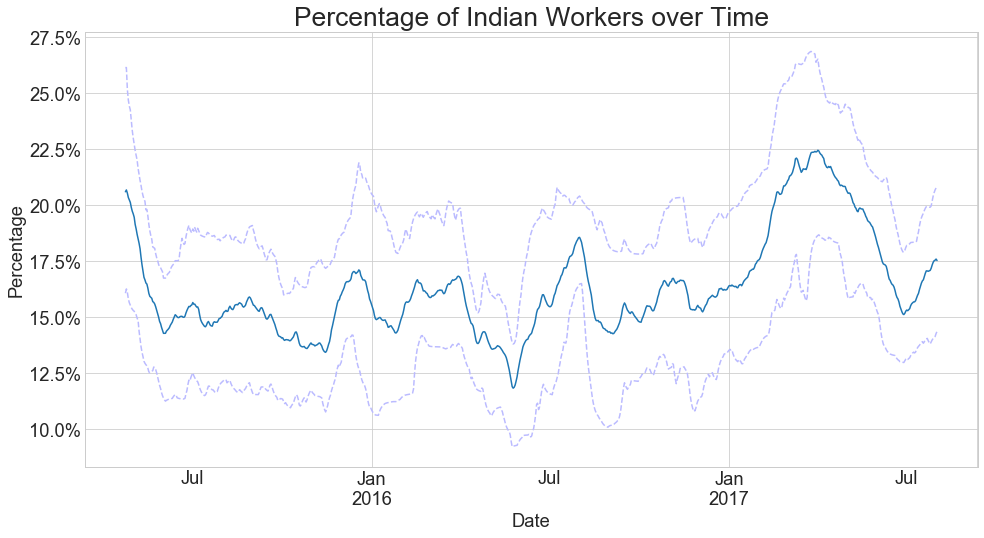

In [26]:
time_plot(100*country_table['IN'], 
          'Percentage of Indian Workers over Time', 
          'plots/country-india.pdf')

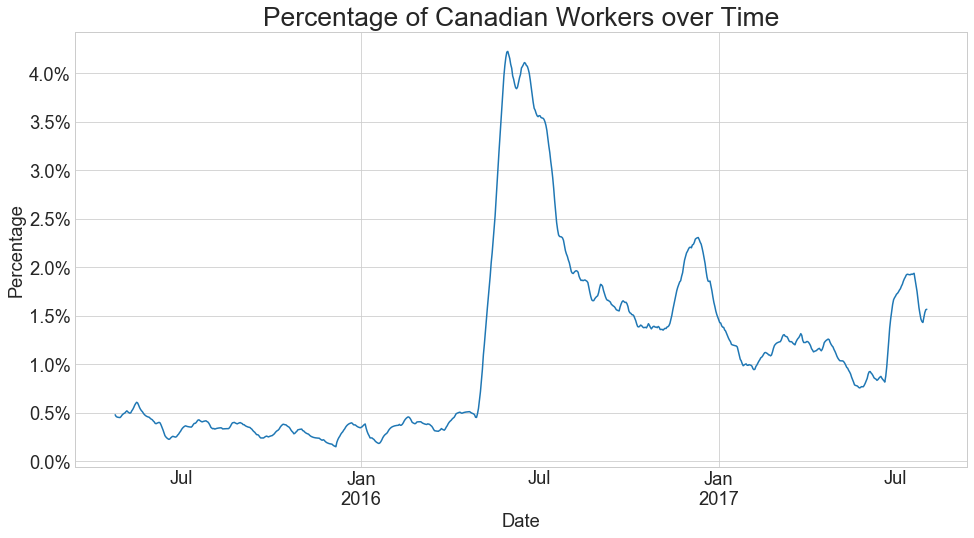

In [27]:
time_plot(data = 100*country_table['CA'], 
          title = 'Percentage of Canadian Workers over Time', 
          filename = 'plots/country-canada.pdf', 
          confidence=False)

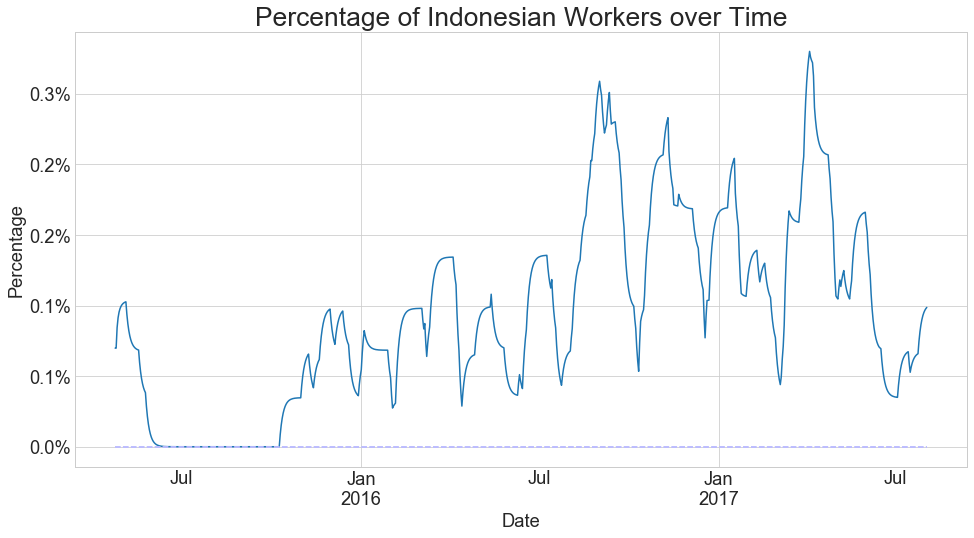

In [28]:
time_plot(100*country_table['ID'], 
          'Percentage of Indonesian Workers over Time', 
          'plots/country-indonesia.pdf')

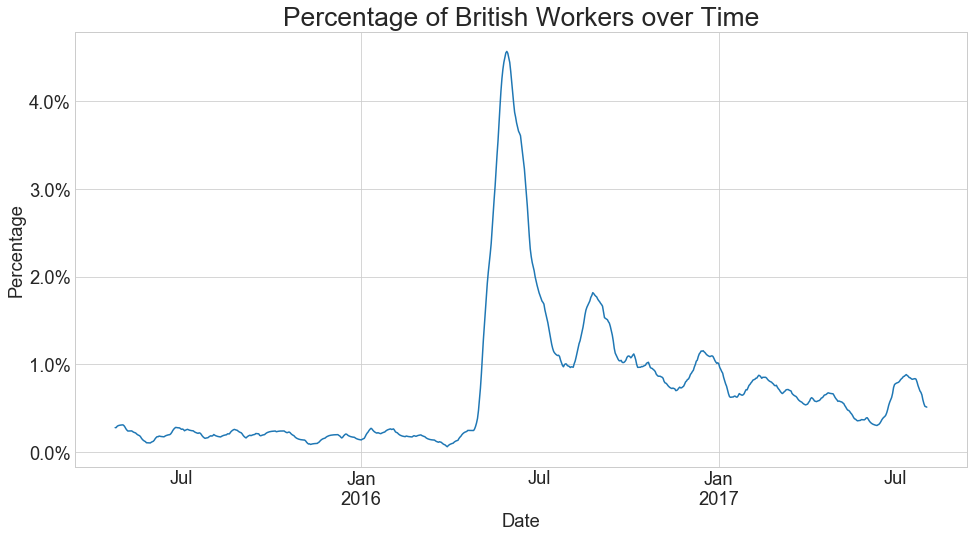

In [29]:
time_plot(data = 100*country_table['GB'], 
          title = 'Percentage of British Workers over Time', 
          filename = 'plots/country-uk.pdf', 
          confidence=False)

## Gender

In [30]:
gender_table = pd.crosstab(index=df.date, columns=df.gender, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [31]:
gender_table.mean()

gender
Female    0.000012
female    0.504229
male      0.495759
dtype: float64

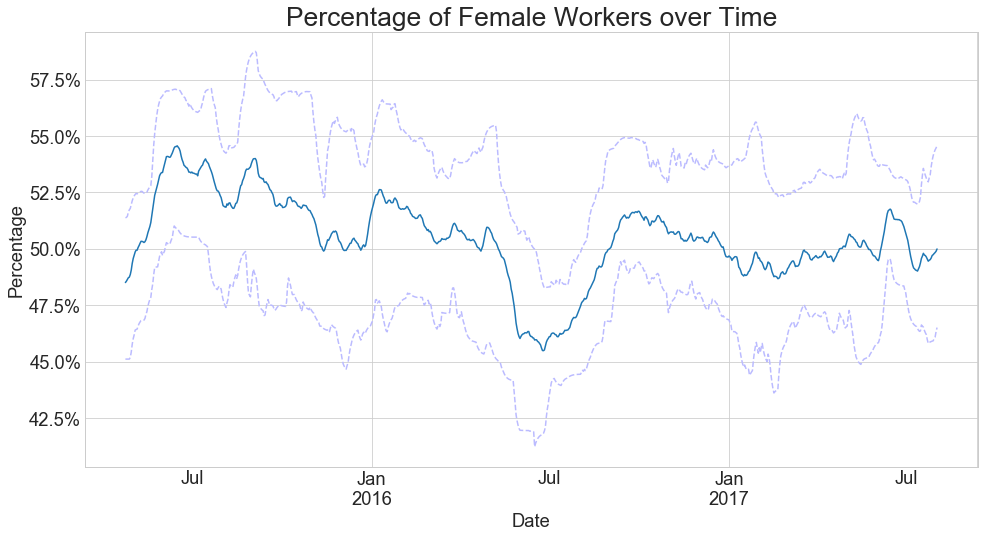

In [32]:
time_plot(data = 100*gender_table['female'], 
          title = 'Percentage of Female Workers over Time', 
          filename = 'plots/gender-female.pdf', 
          confidence=True)

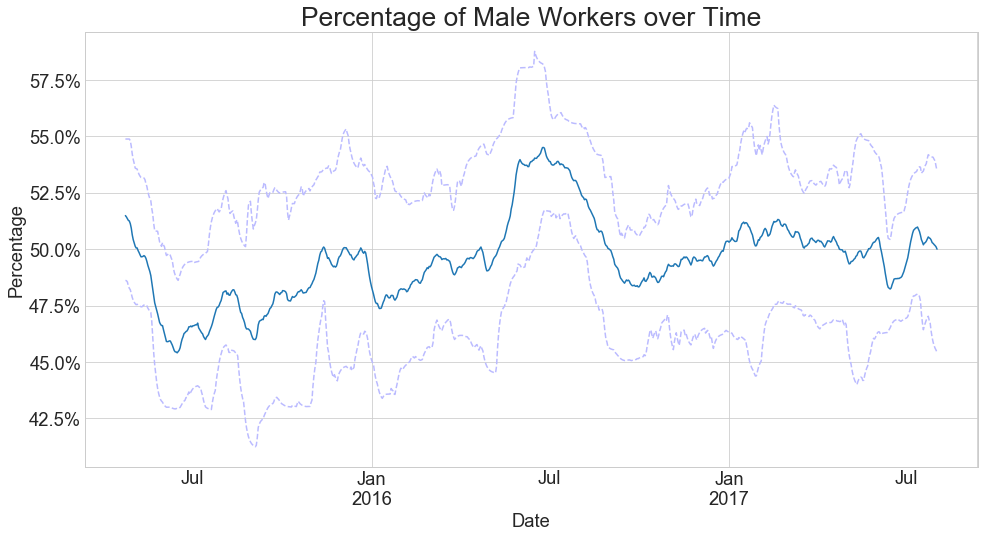

In [33]:
time_plot(data = 100*gender_table['male'], 
          title = 'Percentage of Male Workers over Time', 
          filename = 'plots/gender-male.pdf', 
          confidence=True)

### Gender by Country

In [101]:
gender_by_country = pd.pivot_table(data=df,
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df.location_country,
                             columns=df.gender)

In [109]:

# Keep only US and India
gender_by_country = gender_by_country[gender_by_country.index.isin(['US', 'IN', 'CA', 'GB', 'PH', 'DE'])]
# Normalize and keep percentages
gender_by_country_perc = gender_by_country.apply(lambda x: 100*x / float(x.sum()), axis=1).round(2)
gender_by_country_perc = gender_by_country_perc.reindex(['US', 'IN', 'CA', 'GB', 'PH', 'DE'])

In [110]:
gender_by_country.sum()

gender
Female        1.0
female    41112.0
male      38495.0
dtype: float64

In [111]:
gender_by_country.sum()/gender_by_country.sum().sum()

gender
Female    0.000013
female    0.516431
male      0.483557
dtype: float64

In [112]:
gender_by_country

gender,Female,female,male
location_country,,,
CA,NaN,433.0,524.0
DE,NaN,56.0,174.0
GB,NaN,225.0,378.0
IN,NaN,4885.0,9031.0
PH,NaN,155.0,142.0
US,1.0,35358.0,28246.0


In [117]:
gender_by_country_perc_df = gender_by_country_perc[['female','male']]

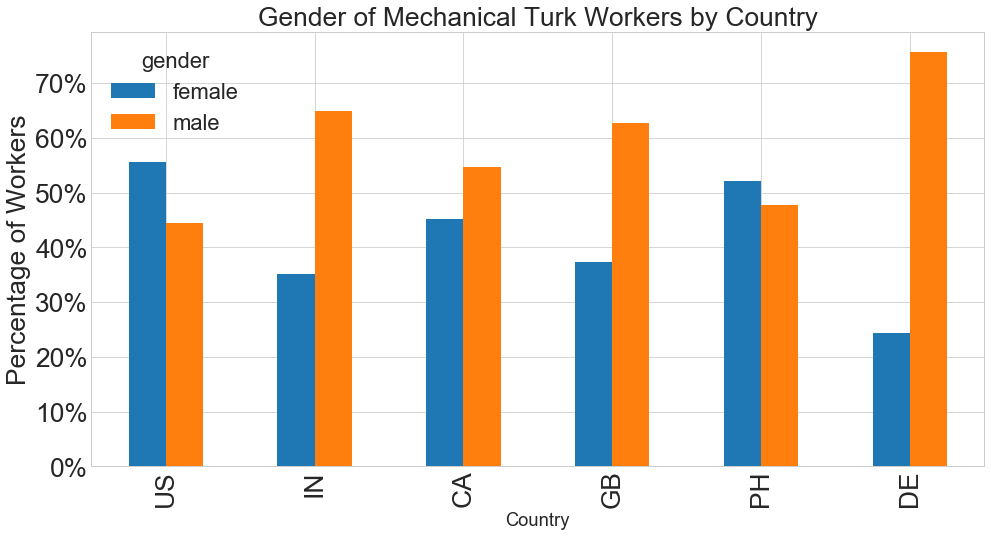

In [119]:
ax = gender_by_country_perc_df.plot.bar(fontsize='large')
ax.set_title("Gender of Mechanical Turk Workers by Country", fontsize='large')
ax.set_xlabel("Country", fontsize='small')
ax.set_ylabel("Percentage of Workers", fontsize='large')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

fig = ax.get_figure()
fig.savefig('plots/gender.pdf', bbox_inches='tight')

### Gender by Country over Time

In [41]:
gender_table_us = pd.crosstab(index=df[df.location_country=='US'].date, columns=df[df.location_country=='US'].gender, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

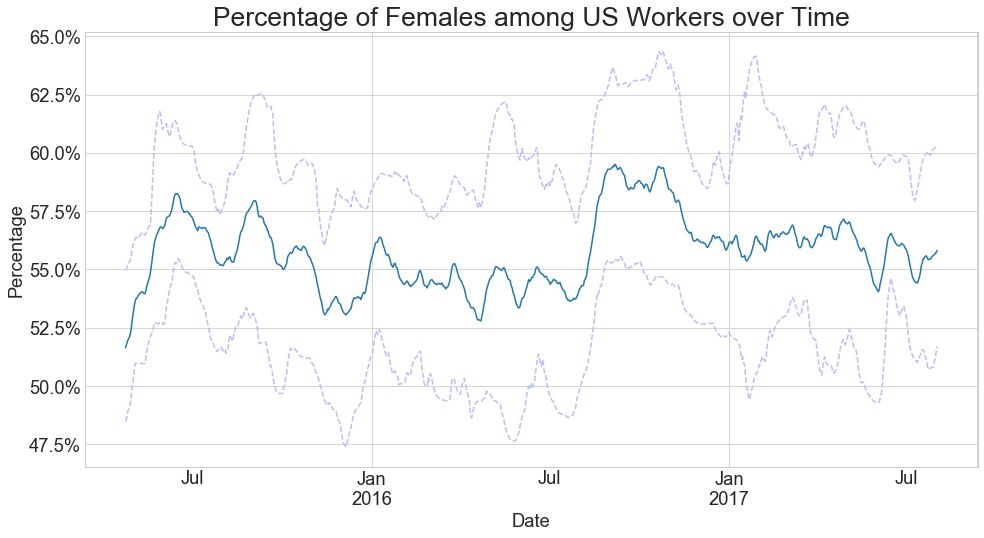

In [42]:
time_plot(data = 100*gender_table_us['female'], 
          title = 'Percentage of Females among US Workers over Time', 
          filename = 'plots/gender-female-usa.pdf', 
          confidence=True)

In [43]:
gender_table_in = pd.crosstab(index=df[df.location_country=='IN'].date, columns=df[df.location_country=='IN'].gender, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

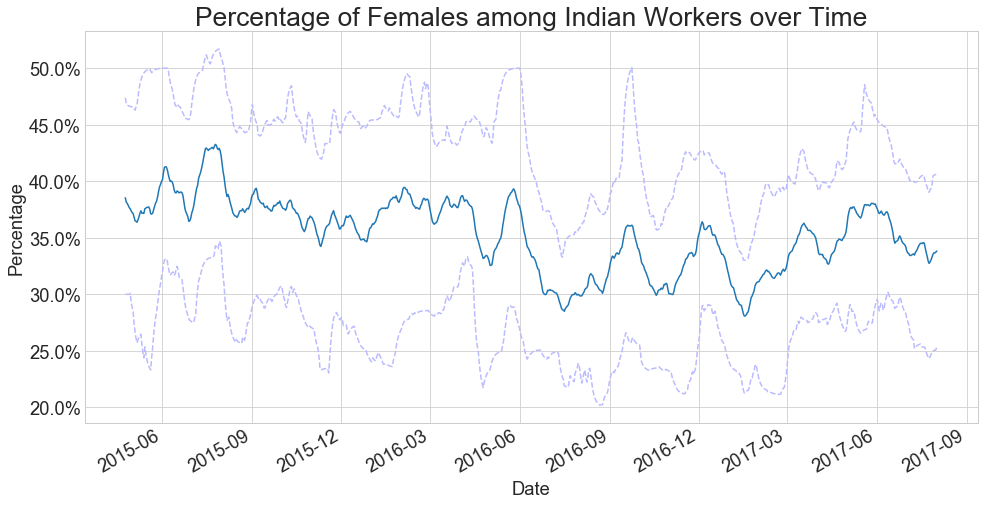

In [44]:
time_plot(data = 100*gender_table_in['female'], 
          title = 'Percentage of Females among Indian Workers over Time', 
          filename = 'plots/gender-female-india.pdf', 
          confidence=True)

### Year of Birth

In [45]:
yob_table = pd.crosstab(index=df.date, columns=df.year_of_birth, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [46]:
yob_table.head(5)

year_of_birth,1910,1912,1913,1914,1915,1918,1919,1920,1921,1922,...,1997,1998,1999,2000,2001,2003,2005,2006,2007,2008
date,,,,,,,,,,,,,,,,,,,,,
2015-03-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


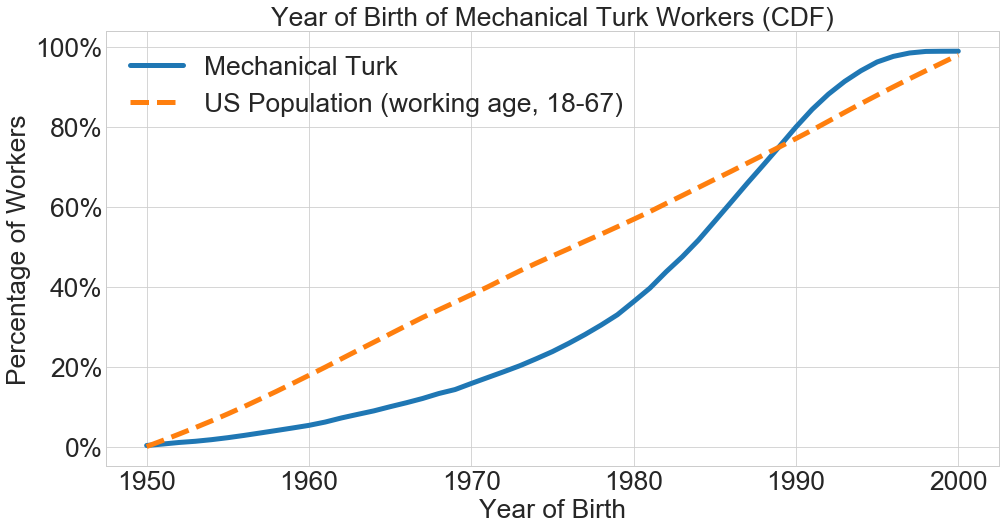

In [47]:
# Limit data to working age
years = [y for y in range(1950,2001)]

# 
yob_df = (100*yob_table[years].mean()).cumsum()
ax = yob_df.plot(fontsize='large', linewidth=5)
ax.set_title("Year of Birth of Mechanical Turk Workers (CDF)", fontsize='large')
ax.set_xlabel("Year of Birth", fontsize='large')
ax.set_ylabel("Percentage of Workers", fontsize='large')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

census = pd.read_csv("census.csv", sep='\t', names  = ['Year of Birth', 'U', 'US Population'])
census.set_index('Year of Birth', inplace=True)
census.drop('U',axis=1, inplace=True)
census.sort_index(inplace=True)
census['US Population'] = 100*census['US Population']
census.plot(ax=ax, linestyle='--', linewidth=5)

ax.legend(['Mechanical Turk', 'US Population (working age, 18-67)'], fontsize='large')

fig = ax.get_figure()
fig.savefig('plots/yearofbirth.pdf', bbox_inches='tight')

In [48]:

census.dtypes

US Population    float64
dtype: object

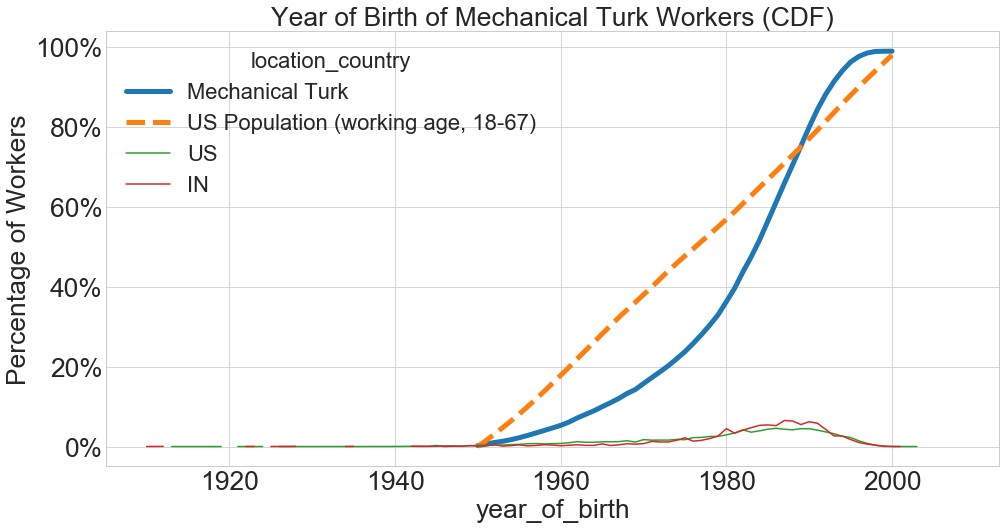

In [49]:
age_by_country = pd.pivot_table(data=df,
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df.year_of_birth,
                             columns=df.location_country)

age_by_country = age_by_country[['US', 'IN']]
age_by_country = 100*age_by_country / age_by_country.sum()
age_by_country.plot(ax = ax)
fig

In [50]:
# Keep only US and India

# Normalize and keep percentages
age_by_country_perc = age_by_country.apply(lambda x: 100*x / float(x.sum()), axis=1).round(2)
# age_by_country_perc = age_by_country_perc.reindex(['US', 'IN', 'CA', 'GB', 'PH', 'DE'])

In [51]:
age_by_country_perc

location_country,US,IN
year_of_birth,,
1910,17.95,82.05
1912,NaN,100.00
1913,100.00,NaN
1914,100.00,NaN
1915,100.00,NaN
1918,6.80,93.20
1919,100.00,NaN
1920,NaN,100.00
1921,100.00,NaN


##### Decade of birth

In [52]:
df['yob_decade'] = df['year_of_birth'].apply(lambda x: str(int(round(x,-1)))+'-'+str(int(round(x,-1))+9))
decades = ['1950-1959', '1960-1969', '1970-1979', '1980-1989', '1990-1999','2000-2009']
yob_table = pd.crosstab(index=df.date, columns=df.yob_decade, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

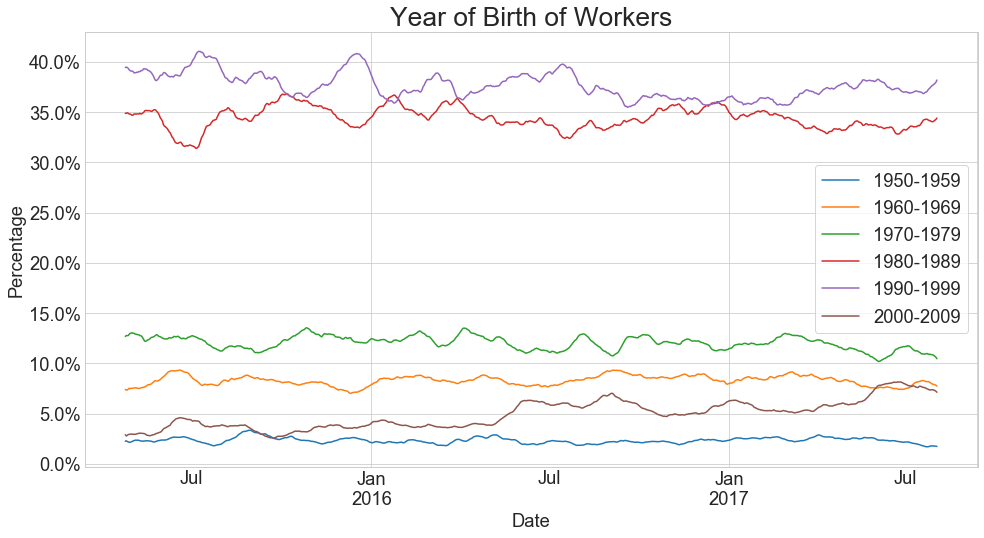

In [53]:
time_plot(100*yob_table[decades], "Year of Birth of Workers", 
          filename = 'plots/decateofbirth.pdf', confidence = False, legend = True)

#### Indian workers are *slightly* younger

In [54]:
data = pd.DataFrame(df[df.location_country=='IN'])
yob_table_in = pd.crosstab(index=data.date, columns=data.yob_decade, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

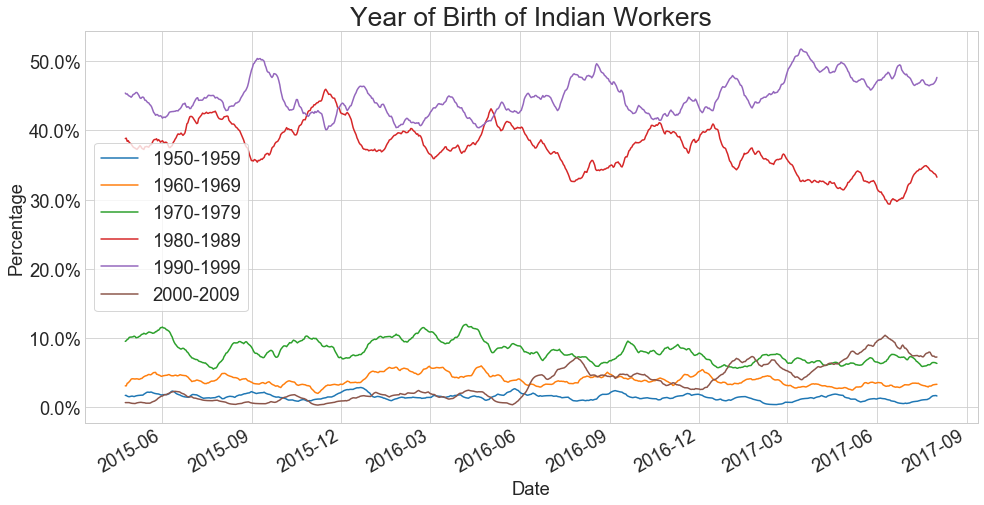

In [55]:
time_plot(100*yob_table_in[decades], "Year of Birth of Indian Workers", 
          'plots/yearofbirth-indian.pdf', confidence = False, legend = True)

### Marital Status

In [56]:
marital_status = pd.pivot_table(data=df,
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df.marital_status)

In [57]:
status = set(df.marital_status)
status.discard('None')
status.discard('separated')
status.discard('widowed')
status = sorted(status)
status

['cohabitating', 'divorced', 'engaged', 'married', 'single']

In [58]:
marital_status = 100* marital_status / marital_status.sum()
marital_status = marital_status.T[status].T

In [59]:
marital_status

,worker_id
marital_status,
cohabitating,9.657914
divorced,5.245471
engaged,2.757038
married,42.076179
single,40.238549


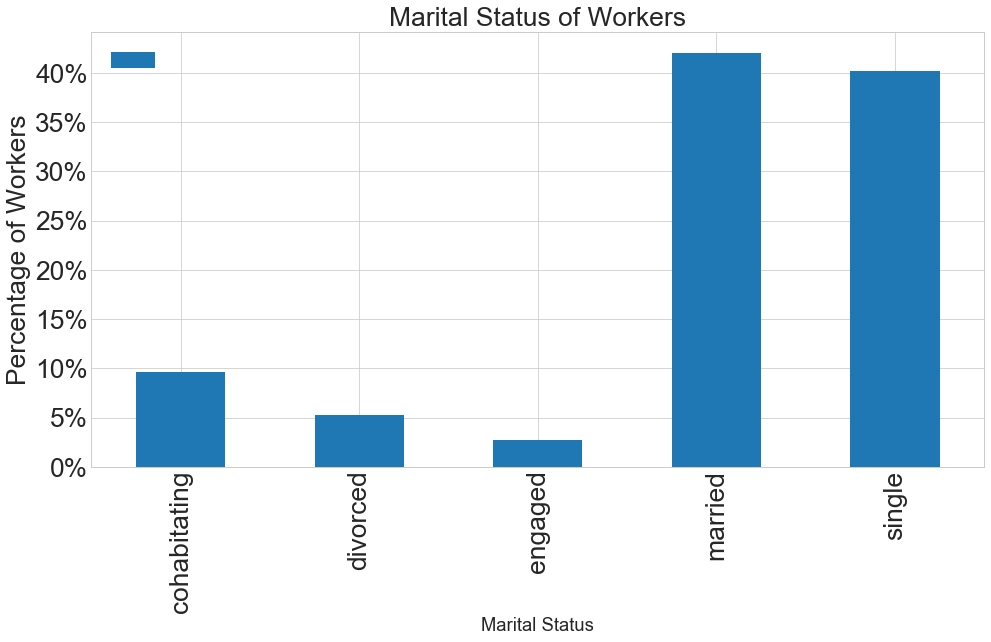

In [60]:
ax = marital_status.plot.bar(fontsize='large')
ax.set_title("Marital Status of Workers", fontsize='large')
ax.set_xlabel("Marital Status", fontsize='small')
ax.set_ylabel("Percentage of Workers", fontsize='large')
ax.legend([''])

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

fig = ax.get_figure()
fig.savefig('plots/marital-status.pdf', bbox_inches='tight')

In [61]:
married_table = pd.crosstab(index=df.date, columns=df.marital_status, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [62]:
status = set(df.marital_status)
status.discard('None')
status.discard('separated')
status.discard('widowed')
status = sorted(status)
status

['cohabitating', 'divorced', 'engaged', 'married', 'single']

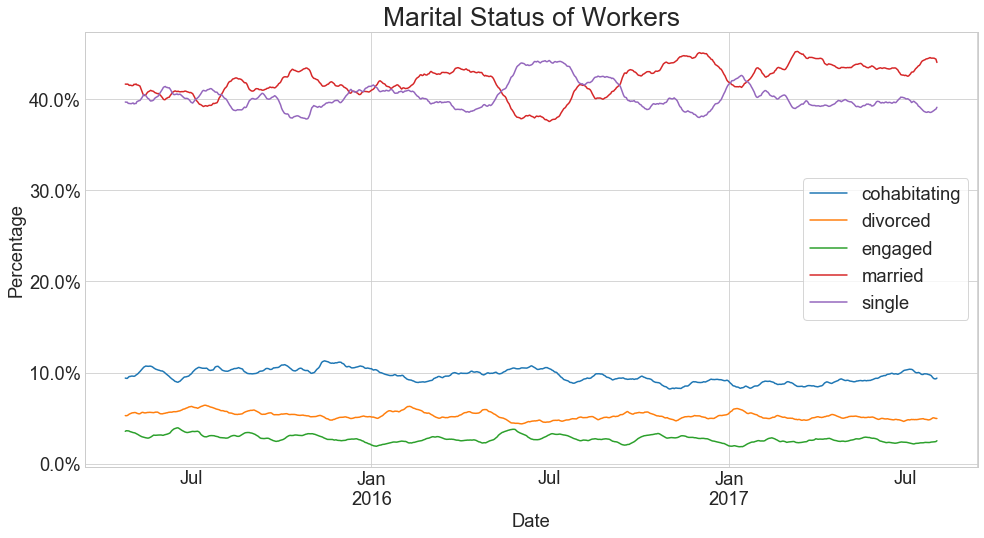

In [63]:
time_plot(100*married_table[status], "Marital Status of Workers", 
          'plots/marital-status.pdf', confidence = False, legend = True)

In [64]:
married_table_in = pd.crosstab(index=df[df.location_country=='IN'].date, columns=df[df.location_country=='IN'].marital_status, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [65]:
status = set(df.marital_status)
status.discard('None')
status.discard('separated')
status.discard('widowed')
status.discard('engaged')
status.discard('divorced')
status.discard('cohabitating')
status = sorted(status)
status

['married', 'single']

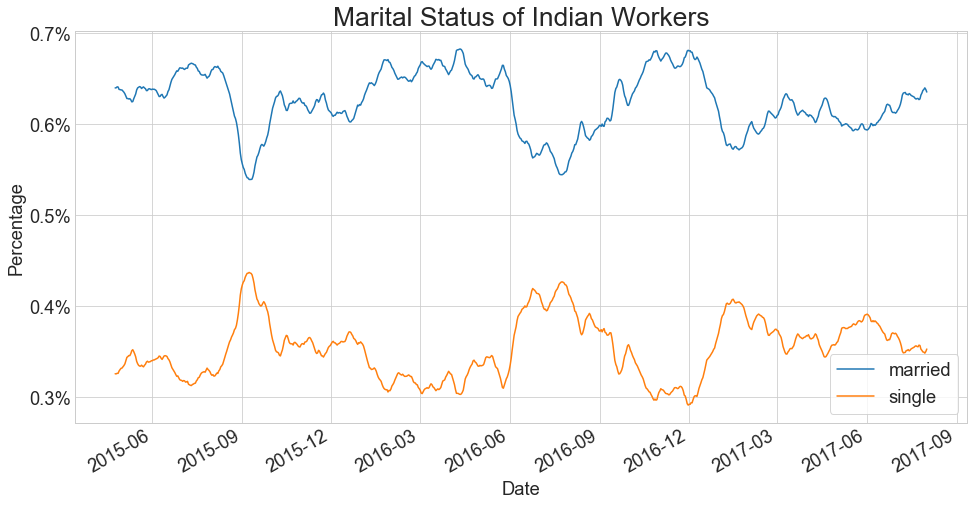

In [66]:
time_plot(married_table_in[status], "Marital Status of Indian Workers",
          'plots/marital-status-indian.pdf', confidence = False, legend = True)

### Household Size



In [67]:
hhsize_table = pd.crosstab(index=df.date, columns=df.household_size, 
                           values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [68]:
status = sorted(set(df.household_size))

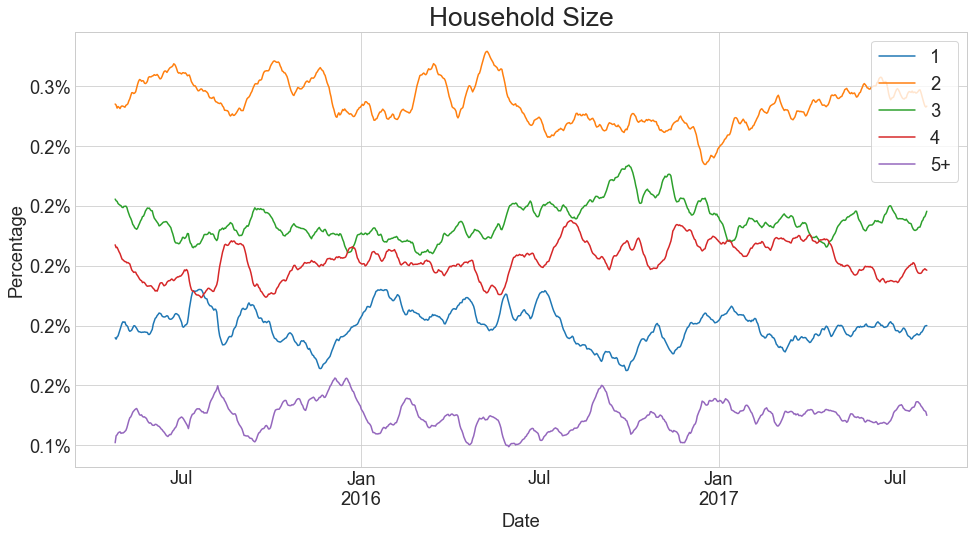

In [69]:
time_plot(hhsize_table[status], "Household Size",
          'plots/hhsize.pdf', confidence = False, legend = True)

#### HHSize for Single and Married People

In [70]:
hhsize_table = pd.crosstab(index=df.date, columns=[df.household_size, df.marital_status], 
                           values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [71]:
import itertools

marital = set(df.marital_status)
marital.discard('None')
marital.discard('separated')
marital.discard('widowed')
marital.discard('engaged')
marital.discard('divorced')
marital.discard('cohabitating')
# marital.discard('single')
marital.discard('married')


hhsize = set(df.household_size)
# hhsize.discard('1')
# hhsize.discard('2')
# hhsize.discard('3')
# hhsize.discard('4')
# hhsize.discard('5+')

status = sorted(itertools.product(hhsize, marital))
status

[('1', 'single'),
 ('2', 'single'),
 ('3', 'single'),
 ('4', 'single'),
 ('5+', 'single')]

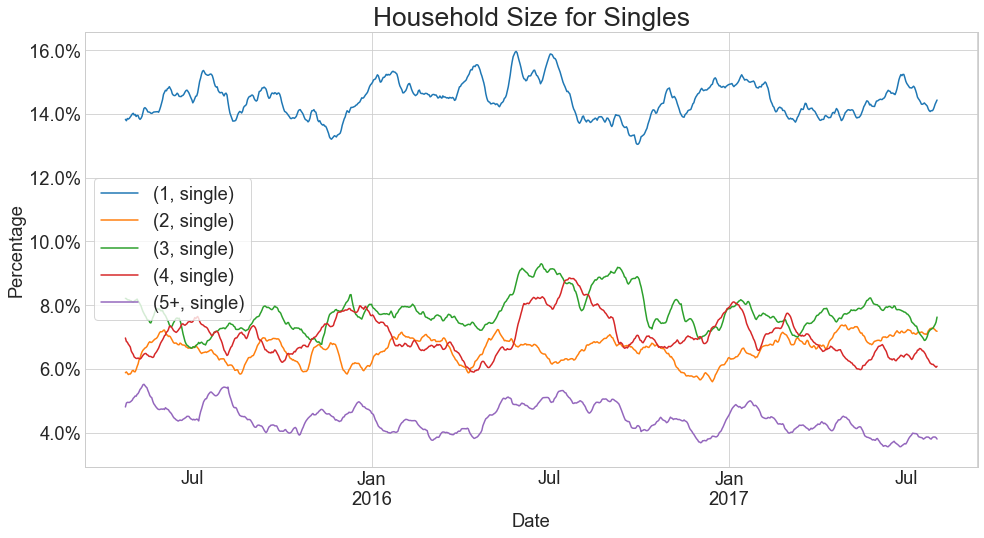

In [72]:
time_plot(100*hhsize_table[status], "Household Size for Singles", 'plots/hhsize-singles.pdf', confidence = False, legend = True)

In [73]:
import itertools

marital = set(df.marital_status)
marital.discard('None')
marital.discard('separated')
marital.discard('widowed')
marital.discard('engaged')
marital.discard('divorced')
marital.discard('cohabitating')
marital.discard('single')
# marital.discard('married')


hhsize = set(df.household_size)
# hhsize.discard('1')
# hhsize.discard('2')
# hhsize.discard('3')
# hhsize.discard('4')
# hhsize.discard('5+')

status = sorted(itertools.product(hhsize, marital))
status

[('1', 'married'),
 ('2', 'married'),
 ('3', 'married'),
 ('4', 'married'),
 ('5+', 'married')]

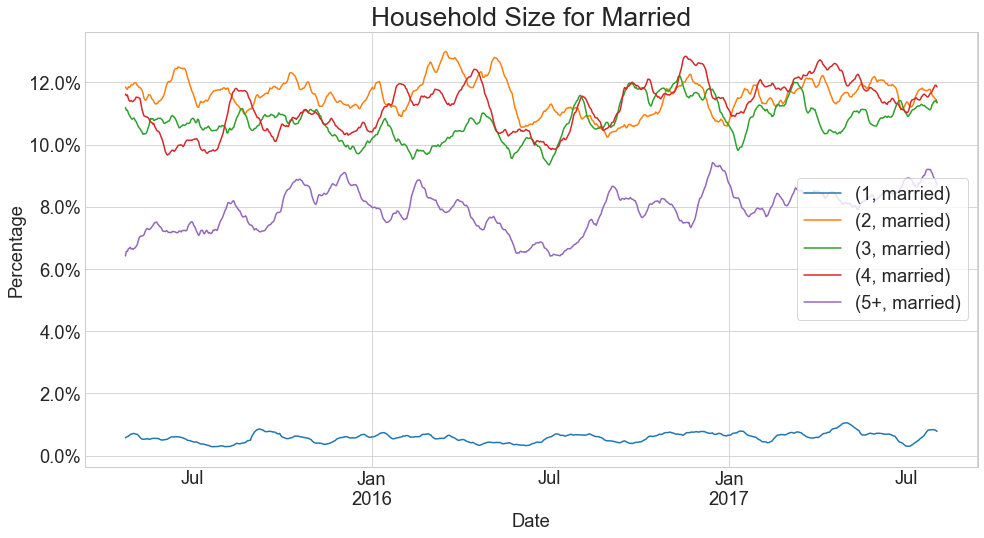

In [74]:
time_plot(100*hhsize_table[status], "Household Size for Married", 'plots/hhsize-married.pdf', confidence = False, legend = True)

### Household Income

In [75]:
df['household_income'] = df['household_income'].apply(lambda x:x.replace('$',''))
income = pd.pivot_table(data=df[df.location_country=='US'],
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df[df.location_country=='US'].household_income)

In [149]:
status = sorted(set(df.household_income))
# Reconfiguring the order
status[0],  status[1], status[7] = status[7], status[0], status[1]
income = income.reindex(status)
income = income / income.sum()
income_df = income.cumsum()*100
income_df

,worker_id
household_income,
"Less than 10,000",6.339124
"10,000-14,999",11.406336
"15,000-24,999",22.358305
"25,000-39,999",41.531326
"40,000-59,999",62.851977
"60,000-74,999",75.454760
"75,000-99,999",87.508844
"100,000 or more",100.000000


In [150]:
# https://en.wikipedia.org/wiki/Household_income_in_the_United_States
census_income_dict = [
{'household_income': 'Less than 10,000', 'US Population' : 3.67},
{'household_income': '10,000-14,999',  'US Population'  : 7.14},
{'household_income': '15,000-24,999',  'US Population' : 18.01},
{'household_income': '25,000-39,999',  'US Population' : 33.63},
{'household_income': '40,000-59,999',  'US Population' : 50.83},
{'household_income': '60,000-74,999',  'US Population' : 60.79},
{'household_income': '75,000-99,999',  'US Population' : 73.45},
{'household_income': '100,000 or more',  'US Population' : 100},   
]
census = pd.DataFrame(census_income_dict)
census.set_index('household_income', inplace=True)


In [151]:
census

,US Population
household_income,
"Less than 10,000",3.67
"10,000-14,999",7.14
"15,000-24,999",18.01
"25,000-39,999",33.63
"40,000-59,999",50.83
"60,000-74,999",60.79
"75,000-99,999",73.45
"100,000 or more",100.00


In [152]:
df_income = income_df.join(census)
df_income.drop('100,000 or more', inplace=True)

In [153]:
rename_dict = {
    'Less than 10,000': 10000,
    '10,000-14,999':  15000,
    '15,000-24,999':  25000,
    '25,000-39,999': 40000,
    '40,000-59,999': 60000,
    '60,000-74,999': 75000,
    '75,000-99,999': 100000}

df_income.rename(index=rename_dict, inplace=True)
df_income

,worker_id,US Population
household_income,,
10000,6.339124,3.67
15000,11.406336,7.14
25000,22.358305,18.01
40000,41.531326,33.63
60000,62.851977,50.83
75000,75.454760,60.79
100000,87.508844,73.45


In [154]:
tmp = pd.DataFrame([{'household_income': 0, 'US Population':0, 'worker_id': 0}]).set_index('household_income')
df_income = df_income.append(tmp).sort_index()

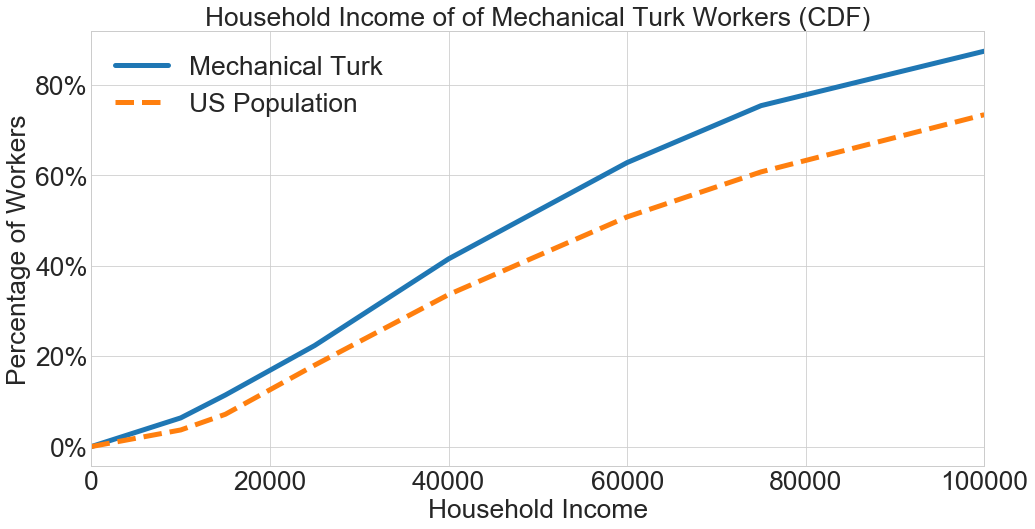

In [155]:
ax = df_income['worker_id'].plot(fontsize='large', linewidth=5)
ax = df_income['US Population'].plot(fontsize='large', linewidth=5, linestyle='--', ax = ax)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.set_xlim([0,100000])


ax.set_title("Household Income of of Mechanical Turk Workers (CDF)", fontsize='large')
ax.set_xlabel("Household Income", fontsize='large')
ax.set_ylabel("Percentage of Workers", fontsize='large')

ax.legend(['Mechanical Turk', 'US Population'], fontsize='large')

fig = ax.get_figure()
fig.savefig('plots/income.pdf', bbox_inches='tight')

In [126]:
hhincome_table = pd.crosstab(index=df.date, columns=df.household_income, 
                           values='worker_id', aggfunc=np.count_nonzero, normalize='index')

status = sorted(set(df.household_income))

# Reconfiguring the order
status[0],  status[1], status[7] = status[7], status[0], status[1]
status

['Less than 10,000',
 '10,000-14,999',
 '15,000-24,999',
 '25,000-39,999',
 '40,000-59,999',
 '60,000-74,999',
 '75,000-99,999',
 '100,000 or more']

In [ ]:
fm = hhincome_table[sorted(status)].ewm(span=30).mean()
fs = hhincome_table[sorted(status)].ewm(span=30).std() 
plt.figure(figsize = (30,20))
plt.tick_params(labelsize=30)

incomes = [fm[d] for d in status]

plt.stackplot(fm.index, incomes, alpha=0.75)
plt.ylim([0.0,1.0])

ax = plt.gca()
ax.set_title("Household Income", fontsize='x-large', y=1.05)
ax.set_ylabel("Percentage of Workers", fontsize='x-large')
ax.set_xlabel("Date", fontsize='x-large')


legend = []
for stat in status:
    s = stat.replace('$','')
    legend.append(s)
    
ax.legend(legend, fontsize='x-large', fancybox=True, frameon = True, loc="upper center", ncol=4, 
         bbox_to_anchor=(0.5, -0.15))